In [ ]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"

1.10.0+cu111
11.1


In [ ]:
! pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
! pip -qq install focal-loss

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.3 MB/s eta 0:12:27tcmalloc: large alloc 1147494400 bytes == 0x5602454fe000 @  0x7fae72c71615 0x56020af724cc 0x56020b05247a 0x56020af752ed 0x56020b066e1d 0x56020afe8e99 0x56020afe39ee 0x56020af76bda 0x56020afe8d00 0x56020afe39ee 0x56020af76bda 0x56020afe5737 0x56020b067c66 0x56020afe4daf 0x56020b067c66 0x56020afe4daf 0x56020b067c66 0x56020afe4daf 0x56020af77039 0x56020afba409 0x56020af75c52 0x56020afe8c25 0x56020afe39ee 0x56020af76bda 0x56020afe5737 0x56020afe39ee 0x56020af76bda 0x56020afe4915 0x56020af76afa 0x56020afe4c0d 0x56020afe39ee
     |██████████████████▌             | 1055.7 MB 1.3 MB/s eta 0:09:28tcmalloc: large alloc 1434370048 bytes == 0x560289b54000 @  0x7fae72c71615 0x56020af724cc 0x56020b05247a 0x56020af752ed 0x56020b066e1d 0x56020afe8e99 0x56020afe39ee 0x56020af76bda 0x56020afe8d00 0x56020afe39ee 0x56020af76bda 0x56020afe5737 0x56020b067c66 0x5602

In [ ]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import time
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Muon project/new-smaples.csv").drop(columns = 'Unnamed: 0')
df = df.drop(columns = [i for i in df.columns if '_1' in i])
df['non_hits'] = df[[i for i in df.columns if 'mask' in i]].sum(axis=1)
df = df[df['non_hits']==0].reset_index(drop=True)

df['1/pT'] = df['q/pt'].abs()
def label(a):
    if a<=10:
        return 0
    if a>10 and a<=30:
        return 1
    if a>30 and a<=100:
        return 2
    if a>100:
        return 3

df['pT'] = 1/df['1/pT']
    
df['pT_classes'] = df['pT'].apply(label)

features = ['emtf_phi_'+str(i) for i in [0,2,3,4]] + ['emtf_theta_'+str(i) for i in [0,2,3,4]] + ['fr_'+str(i) for i in [0,2,3,4]] + ['old_emtf_phi_'+str(i) for i in [0,2,3,4]]
labels_1 = ['pT']
labels_2 = ['pT_classes']
labels_3 = ['vx']

scaler_1 = StandardScaler()
df[features] = scaler_1.fit_transform(df[features])

scaler_3 = MinMaxScaler()
df[labels_3] = scaler_3.fit_transform(df[labels_3])

In [ ]:
df

,emtf_phi_0,emtf_phi_2,emtf_phi_3,emtf_phi_4,emtf_theta_0,emtf_theta_2,emtf_theta_3,emtf_theta_4,emtf_bend_0,emtf_bend_2,emtf_bend_3,emtf_bend_4,emtf_qual_0,emtf_qual_2,emtf_qual_3,emtf_qual_4,emtf_time_0,emtf_time_2,emtf_time_3,emtf_time_4,ring_0,ring_2,ring_3,ring_4,fr_0,fr_2,fr_3,fr_4,old_emtf_phi_0,old_emtf_phi_2,old_emtf_phi_3,old_emtf_phi_4,old_emtf_bend_0,old_emtf_bend_2,old_emtf_bend_3,old_emtf_bend_4,mask_0,mask_2,mask_3,mask_4,ipt,ieta,phi_median,theta_median,q/pt,phi,eta,vx,vy,vz,non_hits,1/pT,pT,pT_classes
0,0.694347,0.992312,1.032076,1.015820,0.874252,0.663437,0.594412,0.486451,7.0,1.0,0.0,0.0,6.0,6.0,-6.0,-5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.010772,0.987201,-0.994134,-0.975562,0.660277,0.990405,1.028145,1.011871,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3846.0,27.0,-0.302635,-1.514912,1.879051,0.709254,0.000011,-2.967770,0.0,0.302635,3.304312,0
1,0.681941,0.651284,0.676773,0.675302,-0.753926,-0.801596,-0.777747,-0.788280,0.0,-4.0,-1.0,0.0,6.0,-6.0,6.0,6.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.010772,-1.012965,1.005900,1.025051,0.676465,0.647427,0.671868,0.671353,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3524.0,12.0,0.027368,3.016775,2.261755,0.409426,-0.000388,-4.839151,0.0,0.027368,36.538564,2
2,1.317535,1.630769,1.713638,1.735551,-0.658151,-0.703927,-0.875758,-0.886336,9.0,3.0,0.0,0.0,-6.0,3.0,-5.0,-6.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,-0.989343,0.987201,-0.994134,-0.975562,1.331572,1.625979,1.709718,1.731600,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4560.0,12.0,-0.376678,2.897855,2.153393,0.396130,0.000280,4.740714,0.0,0.376678,2.654788,0
3,1.559939,1.583297,1.581973,1.574966,-0.849701,-0.801596,-0.777747,-0.788280,-1.0,0.0,0.0,1.0,5.0,-6.0,5.0,6.0,0.0,0.0,-1.0,0.0,4.0,1.0,1.0,1.0,1.010772,-1.012965,1.005900,1.025051,1.551528,1.579473,1.578051,1.568113,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,4.0,0.0,4456.0,12.0,0.009413,-1.960714,2.260267,0.358034,-0.000800,-4.336885,0.0,0.009413,106.233878,3
4,-1.482517,-1.253432,-1.269166,-1.308796,1.832004,1.835463,1.868560,1.957295,6.0,0.0,-2.0,-3.0,6.0,-6.0,6.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.010772,-1.012965,1.005900,1.025051,-1.507860,-1.257357,-1.272165,-1.312740,-2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1511.0,40.0,-0.264267,3.072832,1.722160,0.365747,-0.000668,4.515598,0.0,0.264267,3.784045,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665315,-1.285922,-1.292185,-1.283688,-1.273002,-0.658151,-0.606258,-0.581724,-0.592168,15.0,0.0,0.0,1.0,-6.0,-6.0,5.0,6.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,-0.989343,-1.012965,1.005900,1.025051,-1.222203,-1.288361,-1.279910,-1.273077,-3.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,4.0,0.0,1488.0,14.0,-0.062339,-2.882165,-2.201211,0.404706,0.000348,-1.503398,0.0,0.062339,16.041309,1
665316,0.213357,0.528243,0.582864,0.597912,-0.179275,-0.215583,-0.189678,-0.101886,7.0,4.0,2.0,0.0,-6.0,-5.0,6.0,6.0,0.0,-1.0,0.0,0.0,1.0,1.0,1.0,1.0,-0.989343,-1.012965,1.005900,1.025051,0.244170,0.532132,0.585703,0.600735,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3367.0,19.0,-0.278606,-1.588400,-2.060806,0.603803,0.000839,-1.399982,0.0,0.278606,3.589296,0
665317,-0.525308,-0.191596,-0.095794,-0.059907,-0.849701,-0.996933,-1.071781,-1.180505,11.0,3.0,2.0,0.0,5.0,4.0,-4.0,-4.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.010772,0.987201,-0.994134,-0.975562,-0.542339,-0.186764,-0.095870,-0.055148,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2630.0,10.0,-0.488393,-0.901991,-2.287345,0.594092,0.000178,3.621619,0.0,0.488393,2.047531,0
665318,-0.935676,-0.966659,-0.966142,-0.965375,-1.041252,-1.094602,-1.071781,-1.082449,0.0,0.0,0.0,0.0,-6.0,-5.0,6.0,6.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,-0.989343,-1.012965,1.005900,1.025051,-0.933690,-0.962823,-0.962359,-0.961581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1826.0,9.0,0.036043,-2.703958,-2.324632,0.363957,-0.000187,-0.082033,0.0,0.036043,27.744874,1


In [ ]:
shuffled_list = list(range(len(df)))
random.Random(242).shuffle(shuffled_list)
shuffled_list = np.array_split(np.array(shuffled_list), 10)

In [ ]:
edge_index = torch.tensor([(0,1),(1,2),(2,3),(3,2),(2,1),(1,0)], dtype=torch.long).T
X_data = df[features].to_numpy()
Y_data = df[labels_1].to_numpy()
def process_data(i):
  graph = X_data[i].reshape(-1,4).T
  y = Y_data[i]
  data = Data(x=torch.tensor(graph, dtype=torch.float), y=torch.tensor(y, dtype=torch.float), edge_index=edge_index)
  return data

In [ ]:
class TriggerDataset(Dataset):
    def __init__(self, root, indexes=list(range(len(df))), transform=None, pre_transform=None):
        super(TriggerDataset, self).__init__(root, transform, pre_transform)
        self.indexes = indexes
        self.length = len(self.indexes)

    @property
    def raw_file_names(self):
        return ['vgc']

    @property
    def processed_file_names(self):
        return ['vghv']

    def download(self):
        return None
        
    def process(self):
        return None

    def len(self):
        return self.length

    def get(self, idx):
        return process_data(self.indexes[idx])

In [ ]:
class MPL(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MPL, self).__init__(aggr='add')
        self.mlp1 = torch.nn.Linear(in_channels*2, out_channels)
        self.mlp2 = torch.nn.Linear(in_channels, out_channels)
        self.mlp3 = torch.nn.Linear(2*out_channels, 1)
        self.mlp4 = torch.nn.Linear(2*out_channels, 1)
        self.mlp5 = torch.nn.Linear(in_channels,16)
        self.mlp6 = torch.nn.Linear(out_channels,16)
        self.mlp7 = torch.nn.Linear(16,1)

    def forward(self, x, edge_index):

        msg = self.propagate(edge_index, x=x)
        x = F.relu(self.mlp2(x))
        w1 = F.sigmoid(self.mlp3(torch.cat([x,msg], dim=1)))
        w2 = F.sigmoid(self.mlp4(torch.cat([x,msg], dim=1)))
        out = w1*msg + w2*x
        
        return out

    def message(self, x_i, x_j, edge_index):
        msg = F.relu(self.mlp1(torch.cat([x_i, x_j-x_i], dim=1)))
        w1 = F.tanh(self.mlp5(x_i))
        w2 = F.tanh(self.mlp6(msg))
        w = self.mlp7(w1*w2)
        w = softmax(w, edge_index[0])
        return msg*w

In [ ]:
class MPNN(torch.nn.Module):
    def __init__(self):
      super(MPNN, self).__init__()
      self.conv1 = MPL(4,160 )
      self.conv2 = MPL(160,32)
      self.conv3 = MPL(32,64 )
      self.conv4 = MPL(64,32 )
      self.lin1 = torch.nn.Linear(32*2, 128)
      self.lin2 = torch.nn.Linear(128, 16)
      self.lin3 = torch.nn.Linear(16, 16)
      self.lin4 = torch.nn.Linear(16, 1)
      self.global_att_pool1 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(32, 1)))
      self.global_att_pool2 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(32, 1)))

    def forward(self, data):
      x, edge_index, batch = data.x, data.edge_index, data.batch
      x = F.relu(self.conv1(x, edge_index))
      x = F.relu(self.conv2(x, edge_index))
      x1 = self.global_att_pool1(x, batch)
      x = F.relu(self.conv3(x, edge_index))
      x = F.relu(self.conv4(x, edge_index))
      x2 = self.global_att_pool2(x, batch)
      x = torch.cat([x1, x2], dim=1)
      x = F.relu(self.lin1(x))
      x = F.relu(self.lin2(x))
      x = self.lin3(x)
      x = self.lin4(x).squeeze(1)

      return x

In [ ]:
batch_size = 512
epochs = 50
progress_bar=False

In [ ]:
def mse(outputs, labels):
    weights = torch.tensor(labels<80, dtype=torch.float).to(device)*labels + torch.tensor(labels>=80, dtype=torch.float).to(device)*torch.tensor(labels<160, dtype=torch.float).to(device)*labels*2.4 + torch.tensor(labels>=160, dtype=torch.float).to(device)*10
    error = weights*(((outputs-labels)/labels)**2)
    return torch.mean(error)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_fn(val_batch=1, test_batch=2):

    train_loader = DataLoader(TriggerDataset('./',np.concatenate([shuffled_list[j] for j in range(10) if j not in (val_batch, test_batch)])), batch_size=batch_size, shuffle=True, num_workers = 4) 
    val_loader = DataLoader(TriggerDataset('./',shuffled_list[val_batch]), batch_size=batch_size) 
    test_loader = DataLoader(TriggerDataset('./',shuffled_list[test_batch]), batch_size=batch_size)

    model = MPNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1, factor=0.5)

    m_train_loss = []
    m_val_loss = []
    m_test_loss = []
    min_val_loss = float('inf')
    for epoch in range(epochs):
      train_loss = 0
      val_loss = 0
      if progress_bar:
          pbar = tqdm(train_loader)
      else:
          pbar = train_loader
      for data in pbar:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        labels = data.y
        loss = mse(outputs, labels)
        loss.backward()
        optimizer.step()
        if progress_bar:
          pbar.set_description('MSELoss: '+str(loss.cpu().detach().numpy()))
        train_loss += loss.cpu().detach()/len(train_loader)
#         return 0

      for data in val_loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        labels = data.y
        loss = mse(outputs, labels)
        val_loss += loss.cpu().detach()/len(val_loader)
      if val_loss.detach().numpy()<min_val_loss:
        min_val_loss = val_loss.cpu().detach().numpy()
        torch.save(model.state_dict(), 'model.pth')
      lr_scheduler.step(val_loss)
      print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training MSELoss: ', train_loss.numpy(), '| Validation MSELoss: ', val_loss.numpy())
      m_train_loss.append(train_loss.numpy())
      m_val_loss.append(val_loss.numpy())
      if epoch>20 and min(m_val_loss[-7:])>min_val_loss+0.0001:
        break

    if progress_bar==False:
        plt.plot(range(1,len(m_val_loss)+1), m_val_loss, label='val_loss')
        plt.plot(range(1,len(m_train_loss)+1), m_train_loss, label='train_loss')
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    model = MPNN().to(device)
    model.load_state_dict(torch.load('model.pth'))
    test_loss = 0
    true = []
    preds = []
    for data in test_loader:
      data = data.to(device)
      optimizer.zero_grad()
      outputs = model(data)
      labels = data.y
      true += list(labels.cpu().detach().numpy())
      preds += list(outputs.cpu().detach().numpy())
      loss = mse(outputs, labels)
      test_loss += loss/len(test_loader)
    print('Test MSELoss: ', test_loss.cpu().detach().numpy())
    OOF_preds = pd.DataFrame()
    OOF_preds['true_value'] = true
    OOF_preds['preds'] = preds
    OOF_preds['row'] = shuffled_list[test_batch]
    OOF_preds.to_csv('OOF_preds_'+str(val_batch)+'.csv')
    return 0

Processing...
Done!
Processing...
Done!
Processing...
Done!


Epoch:  1/50 | Training MSELoss:  3.788382 | Validation MSELoss:  2.403999
Epoch:  2/50 | Training MSELoss:  2.4971104 | Validation MSELoss:  2.4929736
Epoch     3: reducing learning rate of group 0 to 5.0000e-03.
Epoch:  3/50 | Training MSELoss:  2.7858613 | Validation MSELoss:  2.9555314
Epoch:  4/50 | Training MSELoss:  2.475404 | Validation MSELoss:  2.4834812
Epoch:  5/50 | Training MSELoss:  2.4174266 | Validation MSELoss:  2.213062
Epoch:  6/50 | Training MSELoss:  2.254516 | Validation MSELoss:  2.1668785
Epoch:  7/50 | Training MSELoss:  2.276321 | Validation MSELoss:  2.0952308
Epoch:  8/50 | Training MSELoss:  2.4870186 | Validation MSELoss:  2.6373549
Epoch     9: reducing learning rate of group 0 to 2.5000e-03.
Epoch:  9/50 | Training MSELoss:  2.5195975 | Validation MSELoss:  2.2367568
Epoch:  10/50 | Training MSELoss:  2.1686163 | Validation MSELoss:  2.171644
Epoch    11: reducing learning rate of group 0 to 1.2500e-03.
Epoch:  11/50 | Training MSELoss:  2.1408966 | Val

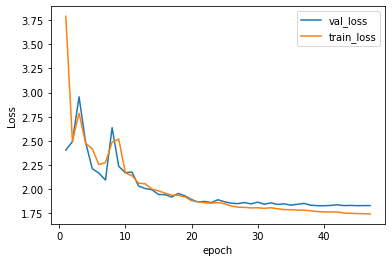

Test MSELoss:  1.8571348


Processing...
Done!
Processing...
Done!
Processing...
Done!


Epoch:  1/50 | Training MSELoss:  4.8190374 | Validation MSELoss:  3.5839615
Epoch:  2/50 | Training MSELoss:  2.6469371 | Validation MSELoss:  2.7866347
Epoch:  3/50 | Training MSELoss:  2.4752975 | Validation MSELoss:  2.3753197
Epoch:  4/50 | Training MSELoss:  2.3013532 | Validation MSELoss:  2.2447884
Epoch:  5/50 | Training MSELoss:  2.2123137 | Validation MSELoss:  2.1038182
Epoch:  6/50 | Training MSELoss:  2.14617 | Validation MSELoss:  2.1983626
Epoch     7: reducing learning rate of group 0 to 5.0000e-03.
Epoch:  7/50 | Training MSELoss:  2.0780454 | Validation MSELoss:  2.2068822
Epoch:  8/50 | Training MSELoss:  1.947446 | Validation MSELoss:  2.0322287
Epoch:  9/50 | Training MSELoss:  1.9277402 | Validation MSELoss:  1.9406254
Epoch:  10/50 | Training MSELoss:  1.9257144 | Validation MSELoss:  2.005683
Epoch    11: reducing learning rate of group 0 to 2.5000e-03.
Epoch:  11/50 | Training MSELoss:  1.9102999 | Validation MSELoss:  1.9953362
Epoch:  12/50 | Training MSELos

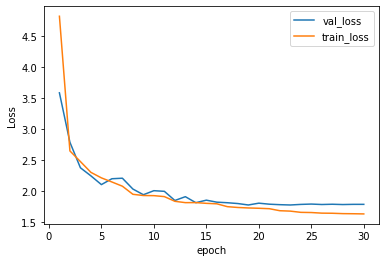

Test MSELoss:  1.7955455


In [ ]:
for i in range(8,10):
    train_fn(val_batch=i, test_batch=(i+1)%10)

In [ ]:
files = os.listdir('/content/')
df = pd.concat([pd.read_csv('/content/'+i).drop(columns = ['Unnamed: 0']) for i in files if 'OOF_preds_' in i])
df.to_csv('OOF_preds.csv')

In [ ]:
df = pd.read_csv('OOF_preds.csv').drop(columns = ['Unnamed: 0'])
df = df.sort_values(by = 'row').reset_index(drop = True)
df['True_pT'] = df['true_value']
df['Predicted_pT'] = df['preds']

In [ ]:
df_cnn = pd.read_csv('/content/OOF_preds.csv').drop(columns = ['Unnamed: 0'])
df_cnn = df_cnn.sort_values(by = 'row').reset_index(drop = True)
df_cnn['True_pT'] = df_cnn['true_value']
df_cnn['Predicted_pT'] = df_cnn['preds']

In [ ]:
df

,true_value,preds,row,True_pT,Predicted_pT
0,3.194292,3.618788,5,3.194292,3.618788
1,3.224163,2.935186,10,3.224163,2.935186
2,4.625931,5.459743,11,4.625931,5.459743
3,2.077774,2.360141,13,2.077774,2.360141
4,5.927949,5.558909,14,5.927949,5.558909
...,...,...,...,...,...
133059,4.508929,4.078331,665291,4.508929,4.078331
133060,3.438781,3.129443,665301,3.438781,3.129443
133061,2.199581,2.360141,665303,2.199581,2.360141
133062,3.015340,2.889321,665308,3.015340,2.889321


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

def MAE(df):
    MAE1 = []
    dx = 0.5
    for i in range(int(2/dx),int(150/dx)):
        P = df[(df['True_pT']>=(i-1)*dx)&(df['True_pT']<=(i+1)*dx)]
        try:
            p = mae(P['True_pT'],P['Predicted_pT'])
        except:
            p=0
        MAE1.append(p)
    MAE1 = MAE1[:196]
    return MAE1

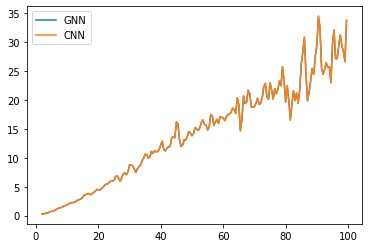

In [ ]:
dx = 0.5
MAE1 = MAE(df)
plt.plot([i*dx for i in range(4,200)],MAE1,label = 'GNN')
plt.plot([i*dx for i in range(4,200)],MAE(df_cnn),label = 'CNN')
plt.legend()
plt.show()

In [ ]:
print(sum(MAE1[:196]))

2787.5314808940766


In [ ]:
def pT_classes(x):
    if x>=25:
        return 'Above 25 GeV'
    else:
        return 'Below 25 GeV'

print(classification_report(df['True_pT'].apply(pT_classes), df['Predicted_pT'].apply(pT_classes)))

              precision    recall  f1-score   support

Above 25 GeV       0.89      0.79      0.84     12610
Below 25 GeV       0.98      0.99      0.98    120454

    accuracy                           0.97    133064
   macro avg       0.94      0.89      0.91    133064
weighted avg       0.97      0.97      0.97    133064

